We used a SBM with two blocks or clusters C1 and C2. Each cluster consists of 10000 nodes. A randomly chosen pair of nodes is connected by an edge with probability 1/5 (1/100) if they belong to the same block (different blocks). The cluster (21) delivered by nLasso (6), with α = 1/10 and λ = 2/sqrt(sum(weights)) and using 10% randomly chosen seed nodes, perfectly recovered the true clusters.

In [1]:
import numpy as np
import random
import math
import datetime

from stochastic_block_model import get_B_and_weight_vec
from sbm import SBM
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, spectral_clustering, SpectralClustering
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
ALPHA = 0.1


def algorithm(B, weight_vec, N1, K=15000, M=0.2, alpha=ALPHA, lambda_nLasso=None, check_s=False):
    E, N = B.shape
    weight_vec = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5
    
    samplingset = random.choices([i for i in range(N1)], k=int(M*N1))

    seednodesindicator= np.zeros(N)
    seednodesindicator[samplingset] = 1
    noseednodeindicator = np.ones(N)
    noseednodeindicator[samplingset] = 0
    
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(weight_vec))
    
    if check_s:
        s = 0.0
        for item in range(len(weight_vec)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += weight_vec[item]
            elif i >= N1 > j:
                s += weight_vec[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * weight_vec), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / (1 + Gamma_vec[samplingset])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)

    return history
    

def run(N1, N2, K=15000, M=0.2, alpha = ALPHA):
    B, weight_vec = get_B_and_weight_vec([N1, N2], mu_in=2, mu_out=0.5, pin=0.2, pout=0.01)
    
    history = algorithm(B, weight_vec, N1, K)
    return history
    

In [3]:
def plot_sparse_charts(history):
    N = len(history[0])
    x_axis = [i for i in range(len(history))]
    plt.plot(x_axis, history[:, -1], label='0', color='green')
    plt.plot(x_axis, history[:, 0], label='1', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('x_hat')
    plt.show()

In [4]:
def plot_full_charts(history):
    N = len(history[0])
    x_axis = [i for i in range(len(history))]
    for i in range(N):
        if i < N/2:
            plt.plot(x_axis, history[:, i], label='1', color='red')
        else:
            plt.plot(x_axis, history[:, i], label='0', color='green')
    plt.xlabel('Iteration')
    plt.ylabel('x_hat')
    plt.show()

Lets start with 100 nodes in each cluster C1, C2 and a total number of 1000 iterations.
At the first plot you can see x_hat for each node in iterations and red lines belong to the nodes in the first cluster and the green lines are for others.

In [5]:
N1, N2 = 100, 100
history = run(N1, N2, K=800)

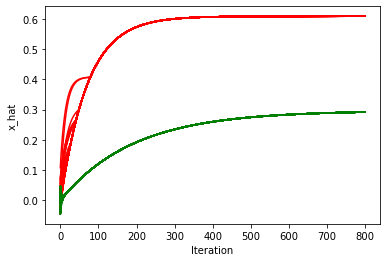

In [6]:
plot_full_charts(history)

As you see, after almost 1000 iterations the result will converge, while we can use kmeans to separate clusters after 40 iterations (only 5% of all needed iterations).

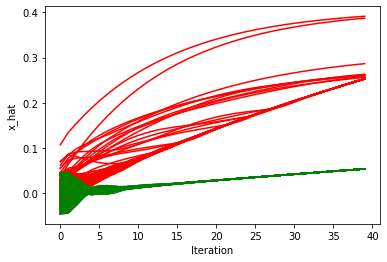

In [7]:
plot_full_charts(history[:40])

In [9]:
X = history[40]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
true_labels = np.array([0 for i in range(N1)] + [1 for i in range(N2)])
if kmeans.labels_[0] == 0:
    print('the accuracy is: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('the accuracy is: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

the accuracy is:  1.0


Here we have 500 nodes in each cluster, and the total number of iterations is 4000.
At the first plot you can see x_hat for each node in iterations and red lines belong to the nodes in the first cluster and the green lines are for others.

In [10]:
N1, N2 = 500, 500
history = run(N1, N2, K=4000)

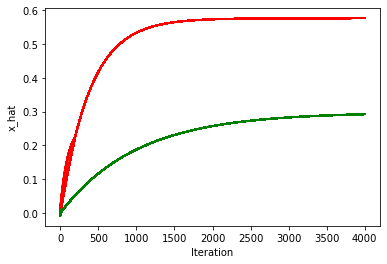

In [11]:
plot_full_charts(history)

As you see, after almost 4000 iterations the result will converge, while we can use kmeans to separate clusters after 200 iterations (only 5% of all needed iterations).

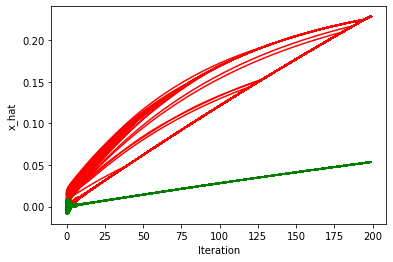

In [12]:
plot_full_charts(history[:200])

In [13]:
X = history[200]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
true_labels = np.array([0 for i in range(N1)] + [1 for i in range(N2)])
if kmeans.labels_[0] == 0:
    print('the accuracy is: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('the accuracy is: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

the accuracy is:  1.0


At the end we have 500 nodes in each cluster, and the total number of iterations is 20000.
At the first plot you can see x_hat for each node in iterations and red lines belong to the nodes in the first cluster and the green lines are for others.

In [14]:
N1, N2 = 5000, 5000
history = run(N1, N2, K=20000)

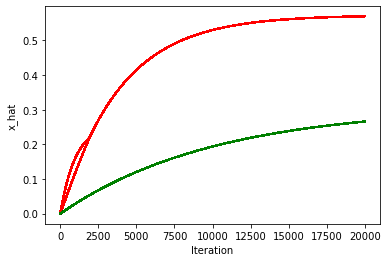

In [15]:
plot_full_charts(history)

As you see, after almost 20000 iterations the result hasn't converge and it need more iterations to converge, while we can use kmeans to separate clusters after 1000 iterations (only 5% of all needed iterations).

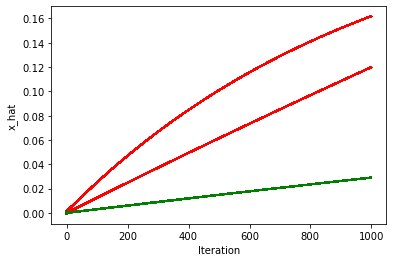

In [16]:
plot_full_charts(history[:1000])

In [17]:
X = history[1000]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
true_labels = np.array([0 for i in range(N1)] + [1 for i in range(N2)])
if kmeans.labels_[0] == 0:
    print('the accuracy is: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('the accuracy is: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

the accuracy is:  1.0


In [5]:
def get_cords(circle_r1=2, circle_r2=4, circle_x=0, circle_y=0):
    alpha = 2 * math.pi * random.random()
    r = (circle_r2-circle_r1) * math.sqrt(random.random()) + circle_r1
    x = r * math.cos(alpha) + circle_x
    y = r * math.sin(alpha) + circle_y
    return x, y


def get_B_and_weight_vec_ring(points):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < 0.00001:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return A, B, weight_vec

def get_points(N1, N2):
    points = []
    for i in range(N1+N2):
        if i < N1:
            x, y = get_cords(2, 4)
        else:
            x, y = get_cords(8, 10)
        points.append((x, y))
    points = np.array(points)
    return points


def run_rings(N1, N2, K=30, alpha=ALPHA, lambda_nLasso=0.1):
    points = get_points(N1, N2)
    A, B, weight_vec = get_B_and_weight_vec_ring(points)
    
    start = datetime.datetime.now()
    history = algorithm(B, weight_vec, N1, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
    print('our method time: ', datetime.datetime.now() - start)
    
    start = datetime.datetime.now()
    spectral_labels = spectral_clustering(A, n_clusters=2)
    print ('spectral clustering time: ', datetime.datetime.now() - start)
    
    return points, history, spectral_labels

Let's compare our method with spectral clustering for a network consisting 2 rings.

At first we have 3000 samples from the inner ring and also 3000 samples from the outer ring.

our method time:  0:00:01.194003


/Users/sahel/anaconda3/envs/aalto/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


spectral clustering time:  0:00:10.604333
our method accuracy:  1.0
spectral clustering accuracy:  1.0


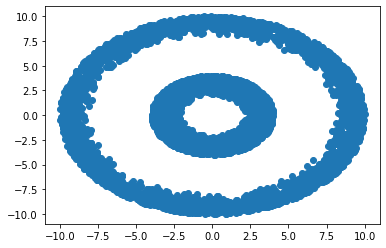

In [6]:
K = 15
N1 = 3000
N2 = 3000
true_labels = np.array([0 for i in range(N1)] + [1 for i in range(N2)])

points, history, spectral_labels = run_rings(N1, N2, K, 1, 0.01)

X = history[-1]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
if kmeans.labels_[0] == 0:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))
    
if spectral_labels[0] == 0:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
else:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    
plt.scatter(points[:, 0], points[:, 1], marker='o', label='Samples')
plt.show()

Second, we have 5000 samples from the inner ring and also 500 samples from the outer ring.

our method time:  0:00:02.723422


/Users/sahel/anaconda3/envs/aalto/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


spectral clustering time:  0:00:10.734997
our method accuracy:  1.0
spectral clustering accuracy:  1.0


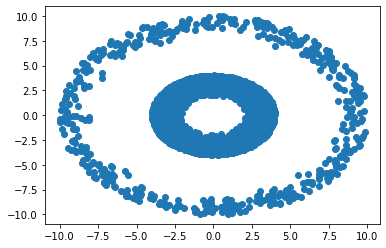

In [7]:
K = 15
N1 = 5000
N2 = 500
true_labels = np.array([0 for i in range(N1)] + [1 for i in range(N2)])

points, history, spectral_labels = run_rings(N1, N2, K, 1, 0.01)


X = history[-1]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
if kmeans.labels_[0] == 0:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))
    
if spectral_labels[0] == 0:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
else:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    
plt.scatter(points[:, 0], points[:, 1], marker='o', label='Samples')
plt.show()

Third, we have 500 samples from the inner ring and also 5000 samples from the outer ring.

our method time:  0:00:00.865007


/Users/sahel/anaconda3/envs/aalto/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


spectral clustering time:  0:00:08.811970
our method accuracy:  1.0
spectral clustering accuracy:  1.0


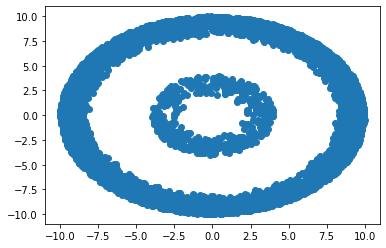

In [8]:
K = 15
N1 = 500
N2 = 5000
true_labels = np.array([0 for i in range(N1)] + [1 for i in range(N2)])

points, history, spectral_labels = run_rings(N1, N2, K, 1, 0.01)


X = history[-1]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
if kmeans.labels_[0] == 0:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))
    
if spectral_labels[0] == 0:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
else:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    
plt.scatter(points[:, 0], points[:, 1], marker='o', label='Samples')
plt.show()

Let's compare our method with spectral clustering for more examples.
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [2]:
import random
import math
import itertools
import numpy as np
from sklearn.cluster import spectral_clustering, SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture

import warnings
warnings.filterwarnings('ignore')

n_samples = 6000

def accuracy(labels, true_labels):
    total_common = 0
    cluster_names = set(true_labels)
    permutations = list(itertools.permutations(cluster_names))
    for permutation in permutations:
        max_common = 0
        for i, cluster_name in enumerate(cluster_names):
            cluster_nodes = np.where(labels == cluster_name)[0]
            cluster_name1 = permutation[i]
            true_nodes = np.where(true_labels == cluster_name1)[0]

            common = len(set(true_nodes) - (set(true_nodes) - set(cluster_nodes)))
            max_common += common

        total_common = max(total_common, max_common)

    return total_common / len(true_labels)

def get_B_and_weight_vec_ring(points, threshhold=0.2):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshhold:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return A, B, weight_vec


def run_more_plots(points, true_labels, K, alpha, lambda_nLasso, threshhold, n_clusters, M=0.2, plot=False, is_print=True):
    A, B, weight_vec = get_B_and_weight_vec_ring(points, threshhold=threshhold)

    print("lambda", n_clusters**3 / (np.sum(weight_vec))**(1/n_clusters))
    E, N = B.shape

    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]
    lambda_weight = lambda_nLasso * weight_vec

    our_labels = np.full(N, n_clusters-1)
    our_time = datetime.datetime.now() - datetime.datetime.now()
    for clust_num in range(n_clusters-1):

        samplingset = random.choices(np.where(true_labels==clust_num)[0], k=int(M * len(np.where(true_labels==clust_num)[0])))
        seednodesindicator = np.zeros(N)
        seednodesindicator[samplingset] = 1
        noseednodeindicator = np.ones(N)
        noseednodeindicator[samplingset] = 0


        hatx = np.zeros(N)
        newx = np.zeros(N)
        prevx = np.zeros(N)
        haty = np.array([x / (E - 1) for x in range(0, E)])
        gamma_plus = 1 + Gamma_vec[samplingset]
        start = datetime.datetime.now()
        for iterk in range(K):
            tildex = 2 * hatx - prevx
            newy = haty + Sigma * B.dot(tildex)  # chould be negative
            res = abs(newy) / lambda_weight
            res[res < 1] = 1
            haty = newy / res

            newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

            newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

            newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
            prevx = np.copy(hatx)
            hatx = newx  # could be negative
        our_time += datetime.datetime.now() - start
        X = newx
        X = np.nan_to_num(X, 0)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
        matched_label = kmeans.labels_[samplingset][0]
        our_labels[np.where(kmeans.labels_ == matched_label)[0]] = clust_num

    our_accuracy = accuracy(our_labels, true_labels)
    our_nmi = normalized_mutual_info_score(our_labels, true_labels)
    if is_print:
        print ('our time is:', our_time)
        print ('our accuracy is:', our_accuracy)
        print ('our nmi is:', our_nmi)
    
    if plot:
        print('our method clusters')
        for label_name in list(set(our_labels)):
            plt.scatter(points[np.where(our_labels == label_name)[0]][:, 0], points[np.where(our_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
    
    start = datetime.datetime.now()
    labels = spectral_clustering(A, n_clusters=n_clusters)
    spectral_time = datetime.datetime.now() - start
    spectral_accuracy = accuracy(labels, true_labels)
    spectral_nmi = normalized_mutual_info_score(labels, true_labels)
    if is_print:
        print ('spectral clustering time is:', spectral_time)
        print ('spectral clustering accuracy is:', spectral_accuracy)
        print ('spectral clustering nmi is:', spectral_nmi)

    
    if plot:
        print('spectral clustering clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(labels == label_name)[0]][:, 0], points[np.where(labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
        print('true clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(true_labels == label_name)[0]][:, 0], points[np.where(true_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    return our_accuracy, our_nmi, our_time, spectral_accuracy, spectral_nmi, spectral_time

     
def run_more_plots_all_together(points, true_labels, K, alpha, lambda_nLasso, threshhold, n_clusters, tmp=0, M=0.2, plot=False, is_print=True):
    A, B, weight_vec = get_B_and_weight_vec_ring(points, threshhold=threshhold)
    
    print("lambda", 5 / math.sqrt(np.sum(weight_vec)))

    E, N = B.shape

    samplingset = random.choices(np.where(true_labels==tmp)[0], k=int(M * len(np.where(true_labels==tmp)[0])))
#     samplingset = random.choices(true_labels, k=int(M * len(true_labels)))
    seednodesindicator = np.zeros(N)
    seednodesindicator[samplingset] = 1
    noseednodeindicator = np.ones(N)
    noseednodeindicator[samplingset] = 0

    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x / (E - 1) for x in range(0, E)])
    lambda_weight = lambda_nLasso * weight_vec
    gamma_plus = 1 + Gamma_vec[samplingset]
    start = datetime.datetime.now()
    for iterk in range(K):
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        res = abs(newy) / lambda_weight
        res[res < 1] = 1
        haty = newy / res

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

        newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
    our_time = datetime.datetime.now() - start
    X = newx
    X = np.nan_to_num(X, 0)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X.reshape(len(X), 1))
    our_accuracy = accuracy(kmeans.labels_, true_labels)
    if is_print:
        print('our time is:', our_time)
        print ('our accuracy is:', our_accuracy)
    
    if plot:
        print('our method clusters')
        for label_name in list(set(kmeans.labels_)):
            plt.scatter(points[np.where(kmeans.labels_ == label_name)[0]][:, 0], points[np.where(kmeans.labels_ == label_name)[0]][:, 1], label='0')
    
        plt.show()
        plt.close()
    

    start = datetime.datetime.now()
    labels = spectral_clustering(A, n_clusters=n_clusters)
    spectral_time = datetime.datetime.now() - start
    spectral_accuracy = accuracy(labels, true_labels)
    if is_print:
        print ('spectral clustering time is:', spectral_time)
        print ('spectral clustering accuracy is:', spectral_accuracy)

    if plot:
        print('spectral clustering clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(labels == label_name)[0]][:, 0], points[np.where(labels == label_name)[0]][:, 1], label='0')
    
        plt.show()
        plt.close()
    
    if plot:
        print('true clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(true_labels == label_name)[0]][:, 0], points[np.where(true_labels == label_name)[0]][:, 1], label='0')
    
        plt.show()
        plt.close()

    return our_accuracy, our_time, spectral_accuracy, spectral_time


In [25]:
def run_noisy_circles(alpha, lambda_lasso, plot=False, is_print=True):
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.3, noise=.05) 

    points = noisy_circles[0] * 2
    true_labels = noisy_circles[1]

    return run_more_plots(points, true_labels, 20, alpha, lambda_lasso, 0.2, 2, plot=plot, is_print=is_print)
 

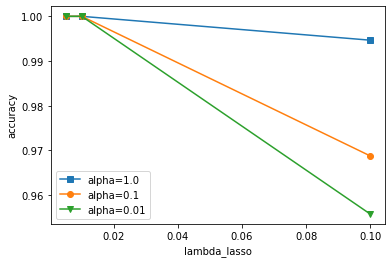

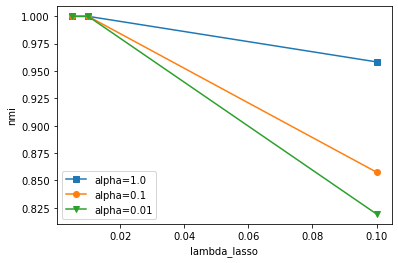

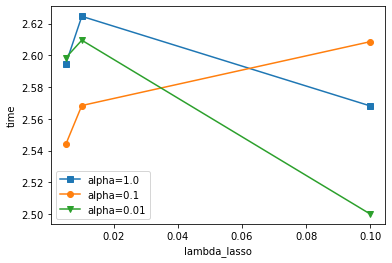

In [29]:
import matplotlib.pyplot as plt
from collections import defaultdict


markers = ['s','o','v','*','^','<','>','1','2','3','4','8','s','P','h','H','+','x','X','D','d','|','_']
lambda_lassos = [0.1, 0.01, 0.005]

our_times_mean = defaultdict(list)
our_times_std = defaultdict(list)

our_nmi_mean = defaultdict(list)
our_nmi_std = defaultdict(list)

for i, alpha in enumerate([1.0, 0.1, 0.01]):
    our_scores_mean = []
    our_scores_std = []
    
    for lambda_lasso in lambda_lassos:
        lambda_accs = []
        lambda_nmis = []
        lambda_times = []
        for _ in range(4):
            our_accuracy, our_nmi, our_time, _, _, _ = run_noisy_circles(alpha, lambda_lasso, is_print=False)
            lambda_accs.append(our_accuracy)
            lambda_nmis.append(our_nmi)
            lambda_times.append(our_time.total_seconds())
            
        our_scores_mean.append(np.mean(lambda_accs))
        our_scores_std.append(np.std(lambda_accs))
        
        our_nmi_mean[alpha].append(np.mean(lambda_nmis))
        our_nmi_std[alpha].append(np.std(lambda_nmis))
        
        our_times_mean[alpha].append(np.mean(lambda_times))
        our_times_std[alpha].append(np.std(lambda_times))
    
    plt.plot(lambda_lassos, our_scores_mean, label='alpha=' + str(alpha), marker=markers[i])
#     plt.errorbar(lambda_lassos, our_scores_mean, yerr=our_scores_std,capsize=3, label='alpha=' + str(alpha))

plt.xlabel('lambda_lasso')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_accuracy_noisy_circles.pdf', format='pdf')
plt.show()
plt.close()  

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_nmi_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])
#     plt.errorbar(lambda_lassos, our_times_mean[alpha], yerr=our_times_std[alpha], 
#                      capsize=3, label='alpha=' + str(alpha))

plt.xlabel('lambda_lasso')
plt.ylabel('nmi')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_nmi_noisy_circles.pdf', format='pdf')
plt.show()
plt.close()



for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_times_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])
#     plt.errorbar(lambda_lassos, our_times_mean[alpha], yerr=our_times_std[alpha], 
#                      capsize=3, label='alpha=' + str(alpha))

plt.xlabel('lambda_lasso')
plt.ylabel('time')
# plt.legend(loc="lower left")
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_time_noisy_circles.pdf', format='pdf')
plt.show()
plt.close()  

accuracy for the automatic tuned lambda
sample: 0
lambda 0.004615017822668486
our time is: 0:00:02.547775
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


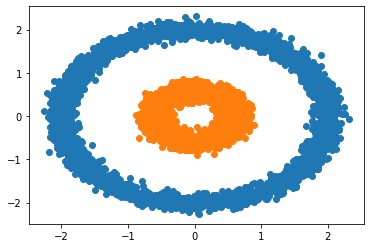

spectral clustering time is: 0:00:04.240884
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


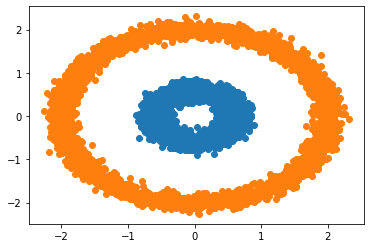

true clusters


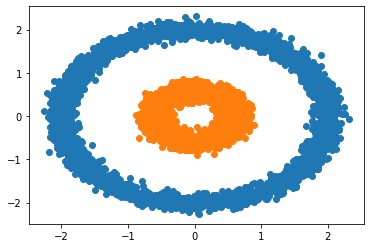

------------------------------

accuracy for the manual tuned lambda
lambda 0.004620957048936431
our time is: 0:00:02.486643
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


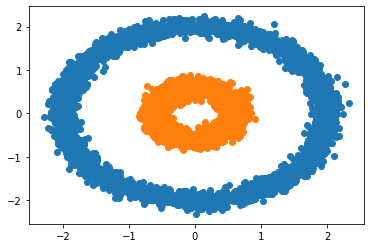

spectral clustering time is: 0:00:03.909336
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


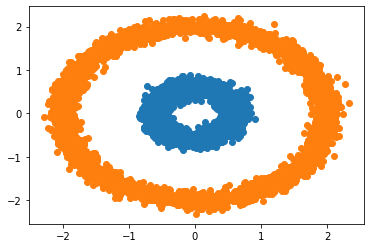

true clusters


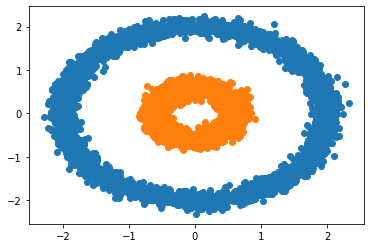

(1.0,
 1.0,
 datetime.timedelta(seconds=2, microseconds=486643),
 1.0,
 1.0,
 datetime.timedelta(seconds=3, microseconds=909336))

In [48]:
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_noisy_circles(0.1, 0.0046, True)
    print('------------------------------')


print()
print("accuracy for the manual tuned lambda")
run_noisy_circles(0.1, 0.005, True)   

In [20]:
import random
import math
import itertools
import numpy as np
from sklearn.cluster import spectral_clustering, SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture

import warnings
warnings.filterwarnings('ignore')

n_samples = 6000

def accuracy(labels, true_labels):
    total_common = 0
    cluster_names = set(true_labels)
    permutations = list(itertools.permutations(cluster_names))
    for permutation in permutations:
        max_common = 0
        for i, cluster_name in enumerate(cluster_names):
            cluster_nodes = np.where(labels == cluster_name)[0]
            cluster_name1 = permutation[i]
            true_nodes = np.where(true_labels == cluster_name1)[0]

            common = len(set(true_nodes) - (set(true_nodes) - set(cluster_nodes)))
            max_common += common

        total_common = max(total_common, max_common)

    return total_common / len(true_labels)

def get_B_and_weight_vec_ring(points, threshhold=0.2):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshhold:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return A, B, weight_vec


def run_more_plots1(points, true_labels, K, alpha, lambda_nLasso, threshhold, n_clusters, M=0.2, plot=False, is_print=True):
    A, B, weight_vec = get_B_and_weight_vec_ring(points, threshhold=threshhold)

#     print("lambda", n_clusters**3 / (np.sum(weight_vec))**(1/n_clusters))
    E, N = B.shape

    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]
    lambda_weight = lambda_nLasso * weight_vec

    our_labels = np.full(N, n_clusters-1)
    our_time = datetime.datetime.now() - datetime.datetime.now()
    signatures = []
    for clust_num in range(n_clusters-1):

        samplingset = random.choices(np.where(true_labels==clust_num)[0], k=int(M * len(np.where(true_labels==clust_num)[0])))
        seednodesindicator = np.zeros(N)
        seednodesindicator[samplingset] = 1
        noseednodeindicator = np.ones(N)
        noseednodeindicator[samplingset] = 0


        hatx = np.zeros(N)
        newx = np.zeros(N)
        prevx = np.zeros(N)
        haty = np.array([x / (E - 1) for x in range(0, E)])
        gamma_plus = 1 + Gamma_vec[samplingset]
        start = datetime.datetime.now()
        for iterk in range(K):
            tildex = 2 * hatx - prevx
            newy = haty + Sigma * B.dot(tildex)  # chould be negative
            res = abs(newy) / lambda_weight
            res[res < 1] = 1
            haty = newy / res

            newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

            newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

            newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
            prevx = np.copy(hatx)
            hatx = newx  # could be negative
        our_time += datetime.datetime.now() - start
        X = newx
        X = np.nan_to_num(X, 0)
        signatures.append(X)

    signatures = np.array(signatures).T
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, algorithm='full').fit(signatures)
    our_labels = kmeans.labels_

    our_accuracy = accuracy(our_labels, true_labels)
    our_nmi = normalized_mutual_info_score(our_labels, true_labels)
    if is_print:
        print ('our time is:', our_time)
        print ('our accuracy is:', our_accuracy)
        print ('our nmi is:', our_nmi)
    
    if plot:
        print('our method clusters')
        for label_name in list(set(our_labels)):
            plt.scatter(points[np.where(our_labels == label_name)[0]][:, 0], points[np.where(our_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
    
    start = datetime.datetime.now()
    labels = spectral_clustering(A, n_clusters=n_clusters)
    spectral_time = datetime.datetime.now() - start
    spectral_accuracy = accuracy(labels, true_labels)
    spectral_nmi = normalized_mutual_info_score(labels, true_labels)
    if is_print:
        print ('spectral clustering time is:', spectral_time)
        print ('spectral clustering accuracy is:', spectral_accuracy)
        print ('spectral clustering nmi is:', spectral_nmi)

    
    if plot:
        print('spectral clustering clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(labels == label_name)[0]][:, 0], points[np.where(labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
        print('true clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(true_labels == label_name)[0]][:, 0], points[np.where(true_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    return our_accuracy, our_nmi, our_time, spectral_accuracy, spectral_nmi, spectral_time
 

sample: 0
lambda 0.004618016166564633
our time is: 0:00:02.457094
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


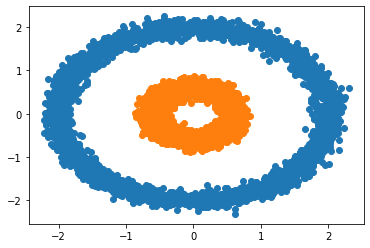

spectral clustering time is: 0:00:03.981384
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


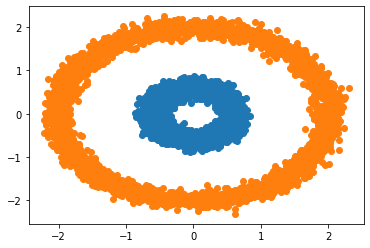

true clusters


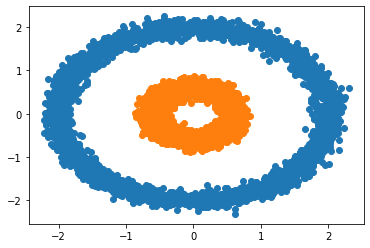

------------------------------
lambda 0.004618934607626608
our time is: 0:00:02.620807
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


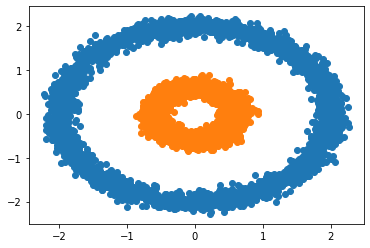

spectral clustering time is: 0:00:04.191660
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


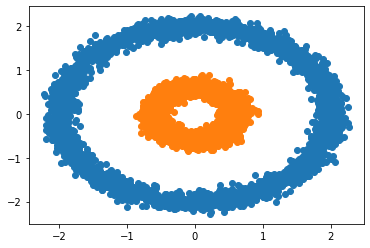

true clusters


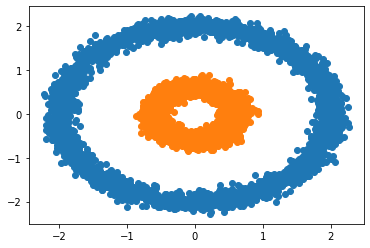

(1.0,
 1.0,
 datetime.timedelta(seconds=2, microseconds=620807),
 1.0,
 1.0,
 datetime.timedelta(seconds=4, microseconds=191660))

In [13]:
def run_noisy_circles1(alpha, lambda_lasso, plot=False, is_print=True):
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.3, noise=.05) 

    points = noisy_circles[0] * 2
    true_labels = noisy_circles[1]

    return run_more_plots1(points, true_labels, 20, alpha, lambda_lasso, 0.2, 2, plot=plot, is_print=is_print)




for i in range(1):
    print('sample:', i)
    run_noisy_circles1(0.1, 0.005, True)
    print('------------------------------')


run_noisy_circles1(0.1, 0.005, True)   

In [49]:
def run_noisy_moons(alpha, lambda_lasso, plot=False, is_print=True):
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

    points = noisy_moons[0] * 3
    true_labels = noisy_moons[1]
    

    return run_more_plots(points, true_labels, 25, alpha, lambda_lasso, 0.2, 2, plot=plot, is_print=is_print)
   

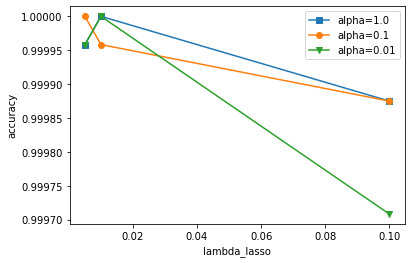

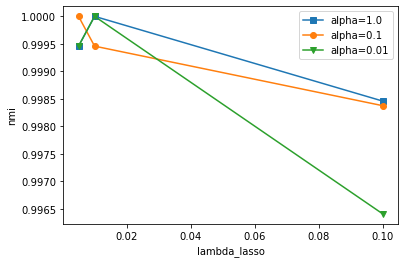

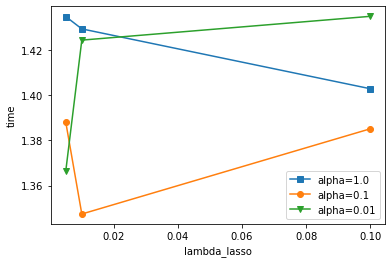

In [32]:
import matplotlib.pyplot as plt
from collections import defaultdict


markers = ['s','o','v','*','^','<','>','1','2','3','4','8','s','P','h','H','+','x','X','D','d','|','_']
lambda_lassos = [0.1, 0.01, 0.005]

our_times_mean = defaultdict(list)
our_times_std = defaultdict(list)

our_nmi_mean = defaultdict(list)
our_nmi_std = defaultdict(list)

for i, alpha in enumerate([1.0, 0.1, 0.01]):
    our_scores_mean = []
    our_scores_std = []
    
    for lambda_lasso in lambda_lassos:
        lambda_accs = []
        lambda_times = []
        lambda_nmis = []
        for _ in range(4):
            our_accuracy, our_nmi, our_time, _, _, _ = run_noisy_moons(alpha, lambda_lasso, is_print=False)
            lambda_accs.append(our_accuracy)
            lambda_nmis.append(our_nmi)
            lambda_times.append(our_time.total_seconds())
            
        our_scores_mean.append(np.mean(lambda_accs))
        our_scores_std.append(np.std(lambda_accs))
        
        our_nmi_mean[alpha].append(np.mean(lambda_nmis))
        our_nmi_std[alpha].append(np.std(lambda_nmis))
        
        our_times_mean[alpha].append(np.mean(lambda_times))
        our_times_std[alpha].append(np.std(lambda_times))
    
    plt.plot(lambda_lassos, our_scores_mean, label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_accuracy_noisy_moons.pdf', format='pdf')
plt.show()
plt.close()  


for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_nmi_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('nmi')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_nmi_noisy_moons.pdf', format='pdf')
plt.show()
plt.close()


for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_times_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('time')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_time_noisy_moons.pdf', format='pdf')
plt.show()
plt.close()  

accuracy for the automatic tuned lambda
sample: 0
lambda 0.006718389614107038
our time is: 0:00:01.314327
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


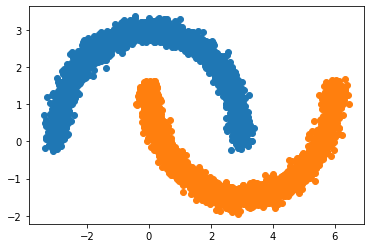

spectral clustering time is: 0:00:04.931735
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


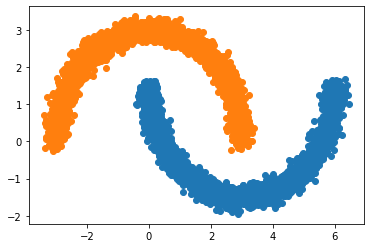

true clusters


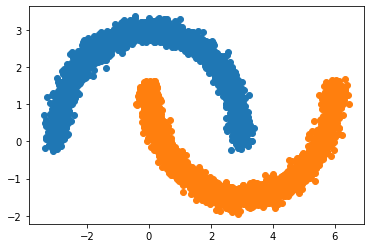

------------------------------

accuracy for the manual tuned lambda
lambda 0.006705497172439464
our time is: 0:00:01.261932
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


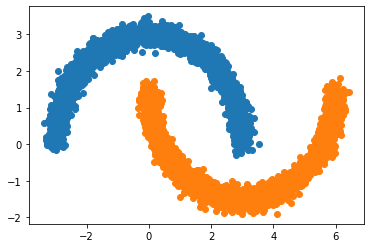

spectral clustering time is: 0:00:04.789736
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


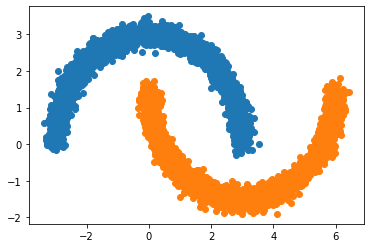

true clusters


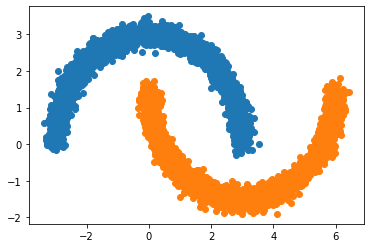

(1.0,
 1.0,
 datetime.timedelta(seconds=1, microseconds=261932),
 1.0,
 1.0,
 datetime.timedelta(seconds=4, microseconds=789736))

In [50]:
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_noisy_moons(0.1, 0.0067, True)
    print('------------------------------')


print()
print("accuracy for the manual tuned lambda")
run_noisy_moons(0.1, 0.005, True) 

sample: 0
lambda 0.006715218403097396
our time is: 0:00:01.438651
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


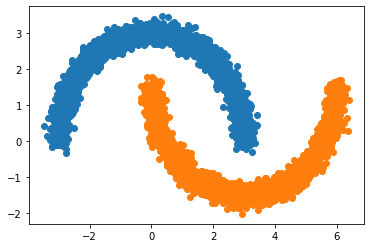

spectral clustering time is: 0:00:05.852102
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


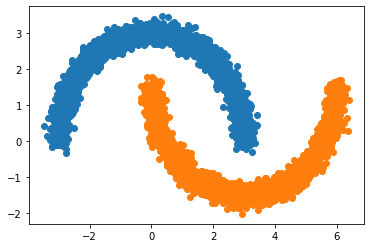

true clusters


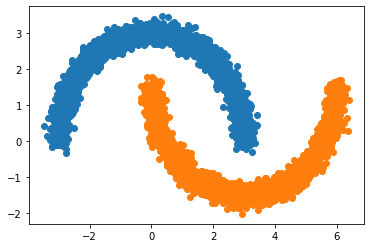

------------------------------
lambda 0.00670740381260603
our time is: 0:00:01.368800
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


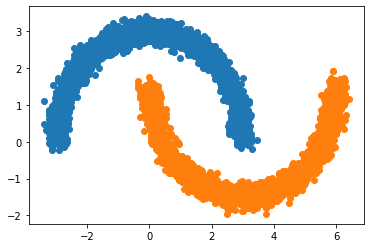

spectral clustering time is: 0:00:06.018159
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


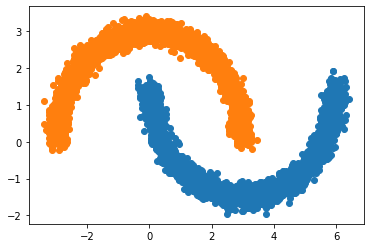

true clusters


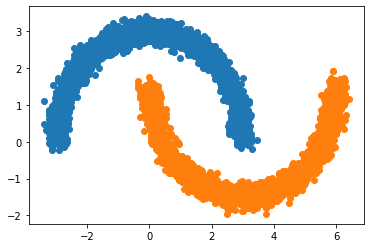

(1.0,
 1.0,
 datetime.timedelta(seconds=1, microseconds=368800),
 1.0,
 1.0,
 datetime.timedelta(seconds=6, microseconds=18159))

In [14]:
def run_noisy_moons1(alpha, lambda_lasso, plot=False, is_print=True):
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

    points = noisy_moons[0] * 3
    true_labels = noisy_moons[1]
    

    return run_more_plots1(points, true_labels, 25, alpha, lambda_lasso, 0.2, 2, plot=plot, is_print=is_print)
   
    
for i in range(1):
    print('sample:', i)
    run_noisy_moons1(0.1, 0.005, True)
    print('------------------------------')


run_noisy_moons1(0.1, 0.005, True) 

In [53]:
def run_blobs(alpha, lambda_lasso, plot=False, is_print=True):
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

    points = blobs[0] 
    true_labels = blobs[1]

#     return run_more_plots(points, true_labels, 20, 1.0, 0.3, 0.009, 3, plot=plot, is_print=is_print)
    return run_more_plots(points, true_labels, 20, alpha, lambda_lasso, 0.009, 3, plot=plot, is_print=is_print)
    

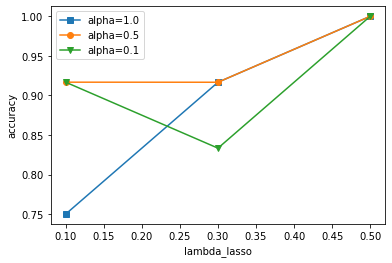

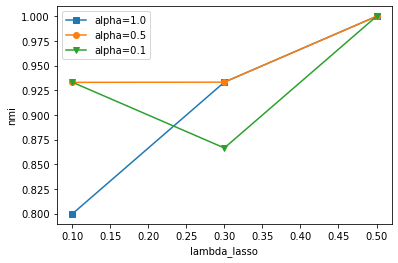

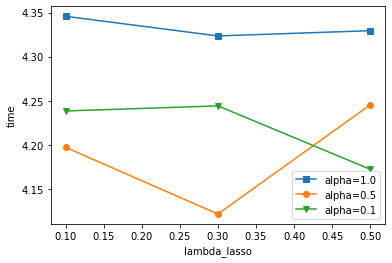

In [36]:
import matplotlib.pyplot as plt
from collections import defaultdict


markers = ['s','o','v','*','^','<','>','1','2','3','4','8','s','P','h','H','+','x','X','D','d','|','_']
lambda_lassos = [0.5, 0.3, 0.1]

our_times_mean = defaultdict(list)
our_times_std = defaultdict(list)

our_nmi_mean = defaultdict(list)
our_nmi_std = defaultdict(list)

for i, alpha in enumerate([1.0, 0.5, 0.1]):
    our_scores_mean = []
    our_scores_std = []
    
    for lambda_lasso in lambda_lassos:
        lambda_accs = []
        lambda_times = []
        lambda_nmis = []
        for _ in range(4):
            our_accuracy, our_nmi, our_time, _, _, _ = run_blobs(alpha, lambda_lasso, is_print=False)
            lambda_accs.append(our_accuracy)
            lambda_nmis.append(our_nmi)
            lambda_times.append(our_time.total_seconds())
            
        our_scores_mean.append(np.mean(lambda_accs))
        our_scores_std.append(np.std(lambda_accs))
        
        our_nmi_mean[alpha].append(np.mean(lambda_nmis))
        our_nmi_std[alpha].append(np.std(lambda_nmis))
        
        our_times_mean[alpha].append(np.mean(lambda_times))
        our_times_std[alpha].append(np.std(lambda_times))
    
    plt.plot(lambda_lassos, our_scores_mean, label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_accuracy_blobs.pdf', format='pdf')
plt.show()
plt.close()  


for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_nmi_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('nmi')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_nmi_blobs.pdf', format='pdf')
plt.show()
plt.close()


for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_times_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('time')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_time_blobs.pdf', format='pdf')
plt.show()
plt.close()  

accuracy for the automatic tuned lambda
sample: 0
lambda 0.2558399130542091
our time is: 0:00:04.055920
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


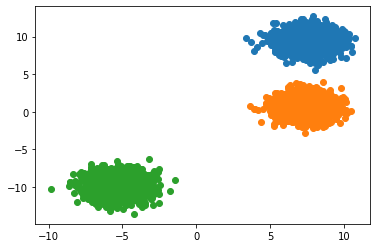

spectral clustering time is: 0:00:05.277730
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


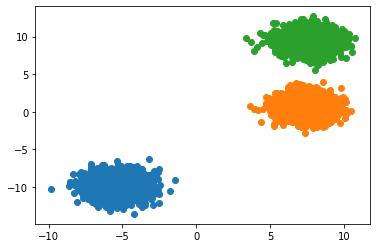

true clusters


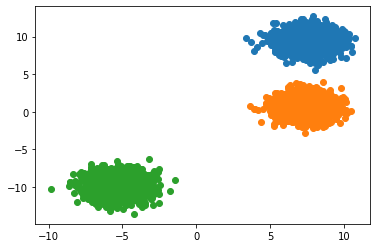

------------------------------

accuracy for the manual tuned lambda
lambda 0.2558399130542091
our time is: 0:00:05.493035
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


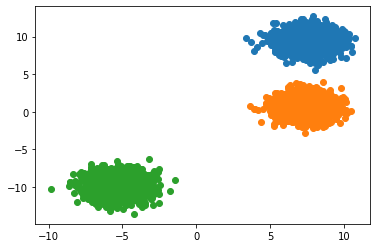

spectral clustering time is: 0:00:05.304860
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


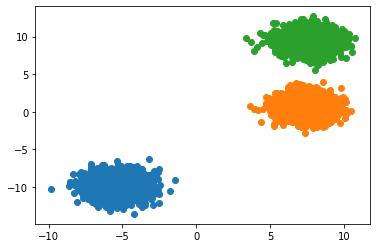

true clusters


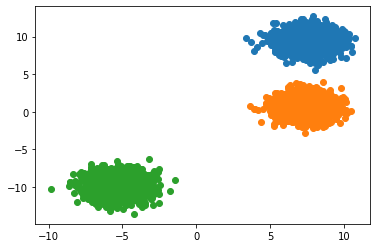

(1.0,
 1.0,
 datetime.timedelta(seconds=5, microseconds=493035),
 1.0,
 1.0,
 datetime.timedelta(seconds=5, microseconds=304860))

In [54]:
# 1.5, 0.5
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_blobs(0.1, 0.255, True)
    print('------------------------------')


print()
print("accuracy for the manual tuned lambda")
run_blobs(0.1, 0.5, True) 

sample: 0
lambda 0.2558399130542091
our time is: 0:00:04.134982
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


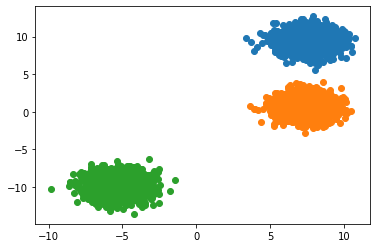

spectral clustering time is: 0:00:04.608638
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


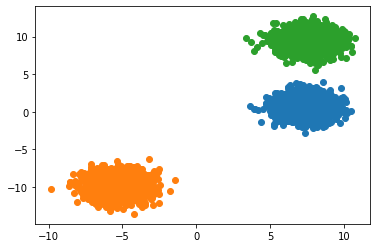

true clusters


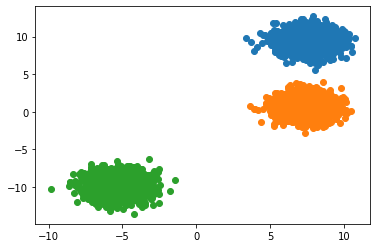

------------------------------
lambda 0.2558399130542091
our time is: 0:00:03.996318
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


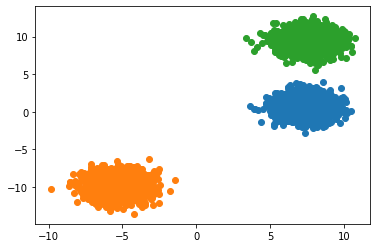

spectral clustering time is: 0:00:04.450649
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


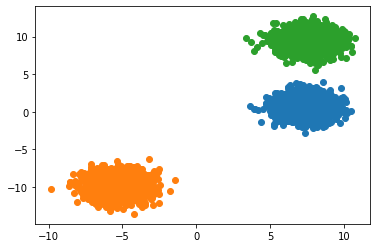

true clusters


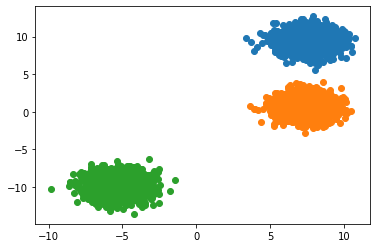

(1.0,
 1.0,
 datetime.timedelta(seconds=3, microseconds=996318),
 1.0,
 1.0,
 datetime.timedelta(seconds=4, microseconds=450649))

In [15]:
def run_blobs1(alpha, lambda_lasso, plot=False, is_print=True):
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

    points = blobs[0] 
    true_labels = blobs[1]

#     return run_more_plots(points, true_labels, 20, 1.0, 0.3, 0.009, 3, plot=plot, is_print=is_print)
    return run_more_plots1(points, true_labels, 20, alpha, lambda_lasso, 0.009, 3, plot=plot, is_print=is_print)
    
    

# 1.5, 0.5
for i in range(1):
    print('sample:', i)
    run_blobs1(0.1, 0.5, True)
    print('------------------------------')


run_blobs1(0.1, 0.5, True) 

In [55]:
def run_varied(alpha, lambda_lasso, plot=False, is_print=True):
    random_state = 170
    varied = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)

    points = varied[0] 
    true_labels = varied[1]

#     return run_more_plots_all_together(points, true_labels, 60, alpha, lambda_lasso, 0.02, 3, plot=plot, is_print=is_print)
    return run_more_plots(points, true_labels, 60, alpha, lambda_lasso, 0.5, 3, plot=plot, is_print=is_print)

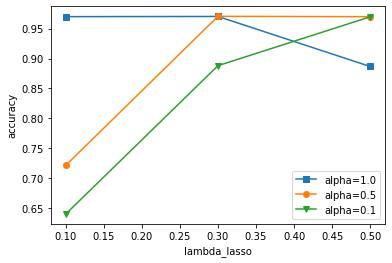

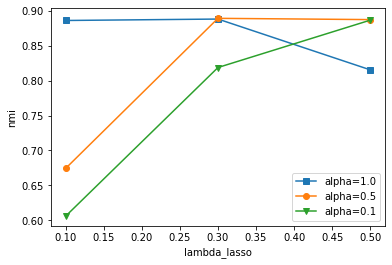

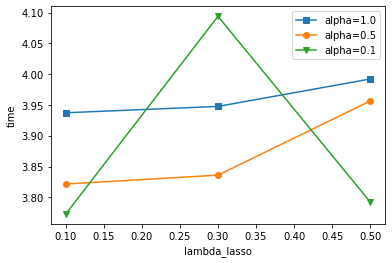

In [39]:
import matplotlib.pyplot as plt
from collections import defaultdict


markers = ['s','o','v','*','^','<','>','1','2','3','4','8','s','P','h','H','+','x','X','D','d','|','_']
lambda_lassos = [0.5, 0.3, 0.1]


our_times_mean = defaultdict(list)
our_times_std = defaultdict(list)

our_nmi_mean = defaultdict(list)
our_nmi_std = defaultdict(list)

for i, alpha in enumerate([1.0, 0.5, 0.1]):
    our_scores_mean = []
    our_scores_std = []
    
    for lambda_lasso in lambda_lassos:
        lambda_accs = []
        lambda_times = []
        lambda_nmis = []
        
        for _ in range(4):
            our_accuracy, our_nmi, our_time, _, _, _ = run_varied(alpha, lambda_lasso, is_print=False)
            lambda_accs.append(our_accuracy)
            lambda_nmis.append(our_nmi)
            lambda_times.append(our_time.total_seconds())
            
        our_scores_mean.append(np.mean(lambda_accs))
        our_scores_std.append(np.std(lambda_accs))
        
        our_nmi_mean[alpha].append(np.mean(lambda_nmis))
        our_nmi_std[alpha].append(np.std(lambda_nmis))
        
        our_times_mean[alpha].append(np.mean(lambda_times))
        our_times_std[alpha].append(np.std(lambda_times))
    
    plt.plot(lambda_lassos, our_scores_mean, label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_accuracy_varied.pdf', format='pdf')
plt.show()
plt.close()  

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_nmi_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('nmi')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_nmi_varied.pdf', format='pdf')
plt.show()
plt.close()

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_times_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('time')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_time_varied.pdf', format='pdf')
plt.show()
plt.close()  

accuracy for the automatic tuned lambda
sample: 0
lambda 0.26615892007762076
our time is: 0:00:03.592825
our accuracy is: 0.64
our nmi is: 0.6068300055981701
our method clusters


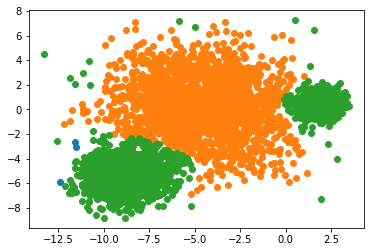

spectral clustering time is: 0:00:11.723603
spectral clustering accuracy is: 0.334
spectral clustering nmi is: 0.0015619080756421788
spectral clustering clusters


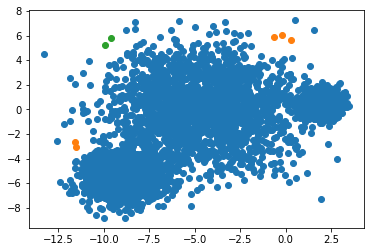

true clusters


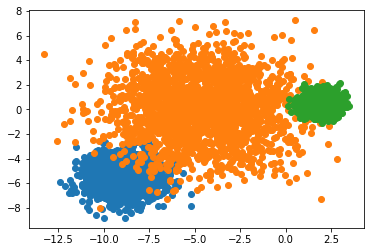

------------------------------

accuracy for the manual tuned lambda
lambda 0.26615892007762076
our time is: 0:00:03.589518
our accuracy is: 0.972
our nmi is: 0.8936092147650349
our method clusters


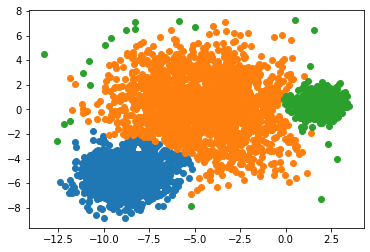

spectral clustering time is: 0:00:11.235566
spectral clustering accuracy is: 0.3338333333333333
spectral clustering nmi is: 0.0016569191291732678
spectral clustering clusters


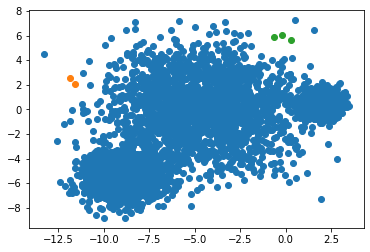

true clusters


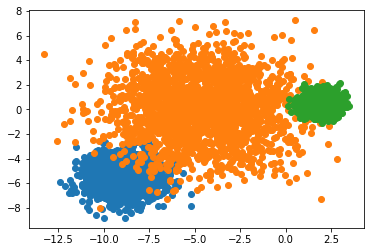

(0.972,
 0.8936092147650349,
 datetime.timedelta(seconds=3, microseconds=589518),
 0.3338333333333333,
 0.0016569191291732678,
 datetime.timedelta(seconds=11, microseconds=235566))

In [57]:
# 0.5, 0.5
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_varied(0.5, 0.266, True)
    print('------------------------------')

print()
print("accuracy for the manual tuned lambda")
run_varied(0.5, 0.3, True)

In [27]:
def run_varied1(alpha, lambda_lasso, plot=False, is_print=True):
    random_state = 170
    varied = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)

    points = varied[0] 
    true_labels = varied[1]

#     return run_more_plots_all_together(points, true_labels, 60, alpha, lambda_lasso, 0.02, 3, plot=plot, is_print=is_print)
    return run_more_plots1(points, true_labels, 60, alpha, lambda_lasso, 0.5, 3, plot=plot, is_print=is_print)


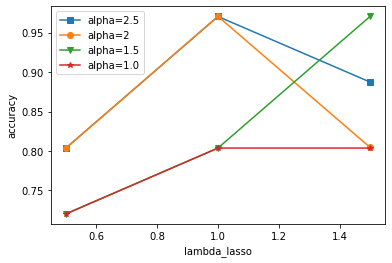

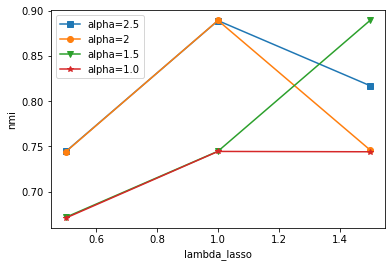

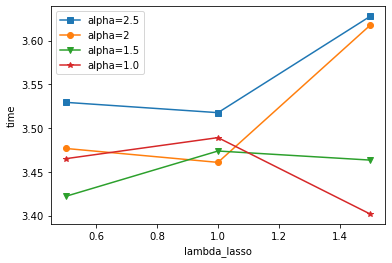

In [40]:
import matplotlib.pyplot as plt
from collections import defaultdict


markers = ['s','o','v','*','^','<','>','1','2','3','4','8','s','P','h','H','+','x','X','D','d','|','_']
lambda_lassos = [1.5, 1.0, 0.5]


our_times_mean = defaultdict(list)
our_times_std = defaultdict(list)

our_nmi_mean = defaultdict(list)
our_nmi_std = defaultdict(list)

for i, alpha in enumerate([2.5, 2, 1.5, 1.0]):
    our_scores_mean = []
    our_scores_std = []
    
    for lambda_lasso in lambda_lassos:
        lambda_accs = []
        lambda_times = []
        lambda_nmis = []
        
        for _ in range(4):
            our_accuracy, our_nmi, our_time, _, _, _ = run_varied1(alpha, lambda_lasso, is_print=False)
            lambda_accs.append(our_accuracy)
            lambda_nmis.append(our_nmi)
            lambda_times.append(our_time.total_seconds())
            
        our_scores_mean.append(np.mean(lambda_accs))
        our_scores_std.append(np.std(lambda_accs))
        
        our_nmi_mean[alpha].append(np.mean(lambda_nmis))
        our_nmi_std[alpha].append(np.std(lambda_nmis))
        
        our_times_mean[alpha].append(np.mean(lambda_times))
        our_times_std[alpha].append(np.std(lambda_times))
    
    plt.plot(lambda_lassos, our_scores_mean, label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('accuracy')
plt.legend(loc='best')
# plt.savefig('alpha_vs_lambda_accuracy_aniso.pdf', format='pdf')
plt.show()
plt.close()  

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_nmi_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('nmi')
plt.legend(loc='best')
# plt.savefig('alpha_vs_lambda_nmi_aniso.pdf', format='pdf')
plt.show()
plt.close()

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_times_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('time')
plt.legend(loc='best')
# plt.savefig('alpha_vs_lambda_time_aniso.pdf', format='pdf')
plt.show()
plt.close()  

sample: 0
our time is: 0:00:03.471825
our accuracy is: 0.9703333333333334
our nmi is: 0.8882029025335232
our method clusters


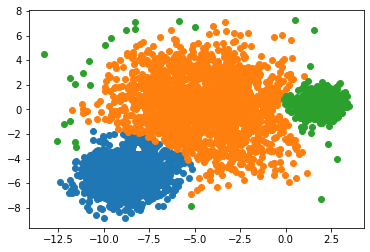

spectral clustering time is: 0:00:11.023163
spectral clustering accuracy is: 0.3343333333333333
spectral clustering nmi is: 0.0027635449305624697
spectral clustering clusters


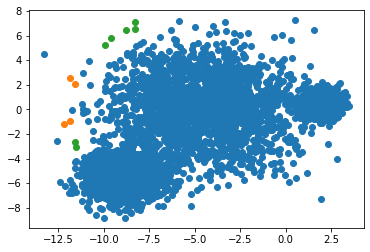

true clusters


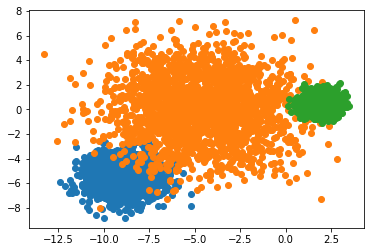

------------------------------
sample: 1
our time is: 0:00:04.193576
our accuracy is: 0.9705
our nmi is: 0.8885420030078308
our method clusters


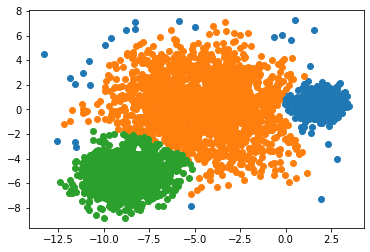

spectral clustering time is: 0:01:15.356976
spectral clustering accuracy is: 0.33366666666666667
spectral clustering nmi is: 0.0013268915636848115
spectral clustering clusters


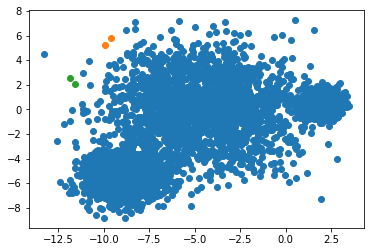

true clusters


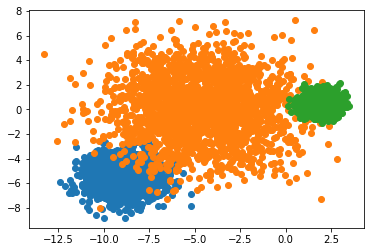

------------------------------
sample: 2
our time is: 0:00:03.461305
our accuracy is: 0.9716666666666667
our nmi is: 0.8924016262528484
our method clusters


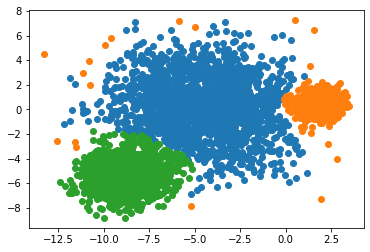

spectral clustering time is: 0:00:12.641670
spectral clustering accuracy is: 0.33366666666666667
spectral clustering nmi is: 0.0013268915636848115
spectral clustering clusters


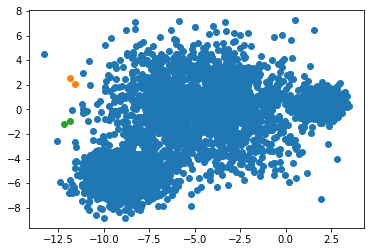

true clusters


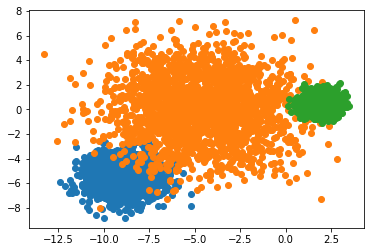

------------------------------
our time is: 0:00:03.524863
our accuracy is: 0.9705
our nmi is: 0.8888341576009947
our method clusters


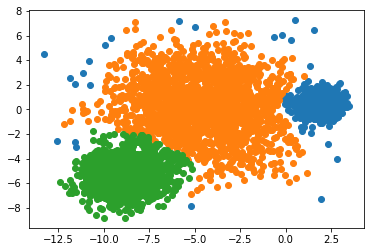

spectral clustering time is: 0:00:08.450808
spectral clustering accuracy is: 0.3343333333333333
spectral clustering nmi is: 0.0026436578733266443
spectral clustering clusters


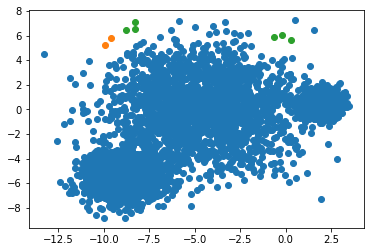

true clusters


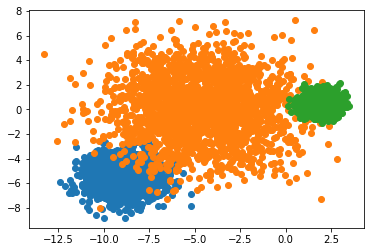

(0.9705,
 0.8888341576009947,
 datetime.timedelta(seconds=3, microseconds=524863),
 0.3343333333333333,
 0.0026436578733266443,
 datetime.timedelta(seconds=8, microseconds=450808))

In [42]:
for i in range(3):
    print('sample:', i)
    run_varied1(1.5, 1.5, True)
    print('------------------------------')

run_varied1(1.5, 1.5, True)

In [58]:
def run_aniso(alpha, lambda_lasso, plot=False, is_print=True):
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    points = aniso[0] 
    true_labels = aniso[1]

    return run_more_plots(points, true_labels, 50, alpha, lambda_lasso, 0.7, 3, plot=plot, is_print=is_print)

    # 1.0, 0.1
#     return run_more_plots_all_together(points, true_labels, 90, alpha, lambda_lasso, 0.4, 3, 1, plot=plot, is_print=is_print)


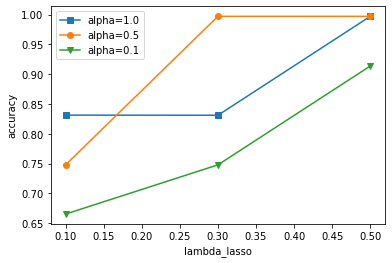

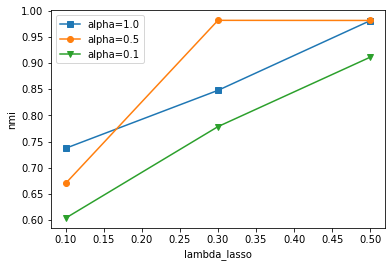

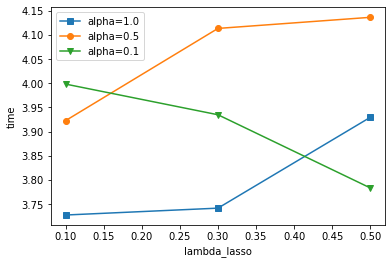

In [42]:
import matplotlib.pyplot as plt
from collections import defaultdict


markers = ['s','o','v','*','^','<','>','1','2','3','4','8','s','P','h','H','+','x','X','D','d','|','_']
lambda_lassos = [0.5, 0.3, 0.1]

our_times_mean = defaultdict(list)
our_times_std = defaultdict(list)

our_nmi_mean = defaultdict(list)
our_nmi_std = defaultdict(list)

for i, alpha in enumerate([1.0, 0.5, 0.1]):
    our_scores_mean = []
    our_scores_std = []
    
    for lambda_lasso in lambda_lassos:
        lambda_accs = []
        lambda_times = []
        lambda_nmis = []
        
        for _ in range(4):
            our_accuracy, our_nmi, our_time, _, _, _ = run_aniso(alpha, lambda_lasso, is_print=False)
            lambda_accs.append(our_accuracy)
            lambda_nmis.append(our_nmi)
            lambda_times.append(our_time.total_seconds())
            
        our_scores_mean.append(np.mean(lambda_accs))
        our_scores_std.append(np.std(lambda_accs))
        
        our_nmi_mean[alpha].append(np.mean(lambda_nmis))
        our_nmi_std[alpha].append(np.std(lambda_nmis))
        
        our_times_mean[alpha].append(np.mean(lambda_times))
        our_times_std[alpha].append(np.std(lambda_times))
    
    plt.plot(lambda_lassos, our_scores_mean, label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_accuracy_aniso.pdf', format='pdf')
plt.show()
plt.close()  

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_nmi_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('nmi')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_nmi_aniso.pdf', format='pdf')
plt.show()
plt.close()

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_times_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('time')
plt.legend(loc='best')
plt.savefig('alpha_vs_lambda_time_aniso.pdf', format='pdf')
plt.show()
plt.close()  

accuracy for the automatic tuned lambda
sample: 0
lambda 0.25093318995781033
our time is: 0:00:03.143682
our accuracy is: 0.9971666666666666
our nmi is: 0.9821657158157394
our method clusters


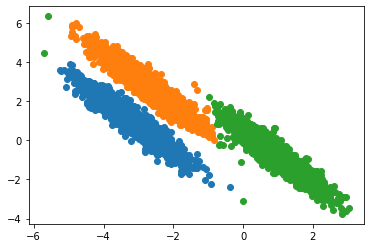

spectral clustering time is: 0:00:05.798192
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025115
spectral clustering clusters


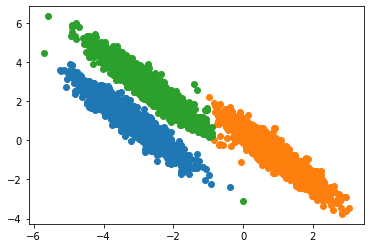

true clusters


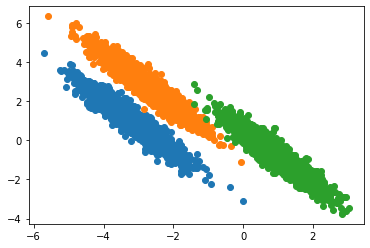

------------------------------

accuracy for the manual tuned lambda
lambda 0.25093318995781033
our time is: 0:00:03.174097
our accuracy is: 0.997
our nmi is: 0.9813186621854559
our method clusters


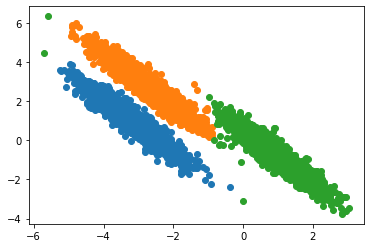

spectral clustering time is: 0:00:07.578032
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025113
spectral clustering clusters


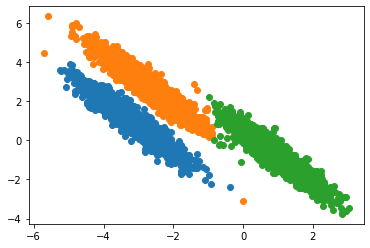

true clusters


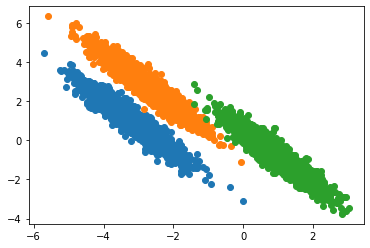

(0.997,
 0.9813186621854559,
 datetime.timedelta(seconds=3, microseconds=174097),
 0.9971666666666666,
 0.9821657930025113,
 datetime.timedelta(seconds=7, microseconds=578032))

In [59]:
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_aniso(1.0, 0.25, True)
    print('------------------------------')


print()
print("accuracy for the manual tuned lambda")
run_aniso(1.0, 0.5, True) 

In [18]:
def run_aniso1(alpha, lambda_lasso, plot=False, is_print=True):
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    points = aniso[0] 
    true_labels = aniso[1]

    return run_more_plots1(points, true_labels, 50, alpha, lambda_lasso, 0.7, 3, plot=plot, is_print=is_print)



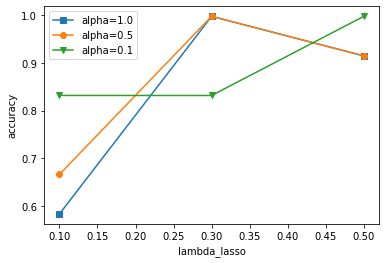

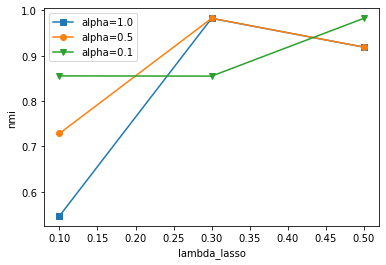

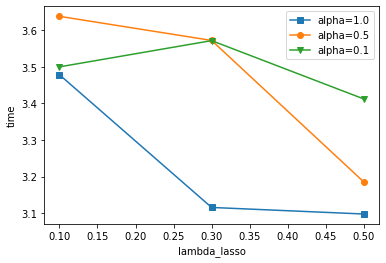

In [24]:
import matplotlib.pyplot as plt
from collections import defaultdict


markers = ['s','o','v','*','^','<','>','1','2','3','4','8','s','P','h','H','+','x','X','D','d','|','_']
lambda_lassos = [0.5, 0.3, 0.1]

our_times_mean = defaultdict(list)
our_times_std = defaultdict(list)

our_nmi_mean = defaultdict(list)
our_nmi_std = defaultdict(list)

for i, alpha in enumerate([1.0, 0.5, 0.1]):
    our_scores_mean = []
    our_scores_std = []
    
    for lambda_lasso in lambda_lassos:
        lambda_accs = []
        lambda_times = []
        lambda_nmis = []
        
        for _ in range(4):
            our_accuracy, our_nmi, our_time, _, _, _ = run_aniso1(alpha, lambda_lasso, is_print=False)
            lambda_accs.append(our_accuracy)
            lambda_nmis.append(our_nmi)
            lambda_times.append(our_time.total_seconds())
            
        our_scores_mean.append(np.mean(lambda_accs))
        our_scores_std.append(np.std(lambda_accs))
        
        our_nmi_mean[alpha].append(np.mean(lambda_nmis))
        our_nmi_std[alpha].append(np.std(lambda_nmis))
        
        our_times_mean[alpha].append(np.mean(lambda_times))
        our_times_std[alpha].append(np.std(lambda_times))
    
    plt.plot(lambda_lassos, our_scores_mean, label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('accuracy')
plt.legend(loc='best')
# plt.savefig('alpha_vs_lambda_accuracy_aniso.pdf', format='pdf')
plt.show()
plt.close()  

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_nmi_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('nmi')
plt.legend(loc='best')
# plt.savefig('alpha_vs_lambda_nmi_aniso.pdf', format='pdf')
plt.show()
plt.close()

for i, alpha in enumerate(our_times_mean):
    plt.plot(lambda_lassos, our_times_mean[alpha], label='alpha=' + str(alpha), marker=markers[i])

plt.xlabel('lambda_lasso')
plt.ylabel('time')
plt.legend(loc='best')
# plt.savefig('alpha_vs_lambda_time_aniso.pdf', format='pdf')
plt.show()
plt.close()  

sample: 0
our time is: 0:00:03.387834
our accuracy is: 0.9973333333333333
our nmi is: 0.9830345149117167
our method clusters


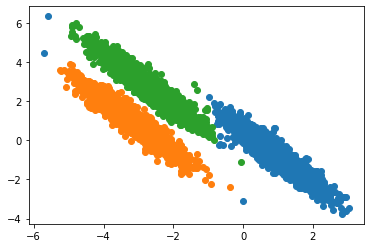

spectral clustering time is: 0:00:06.394477
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025113
spectral clustering clusters


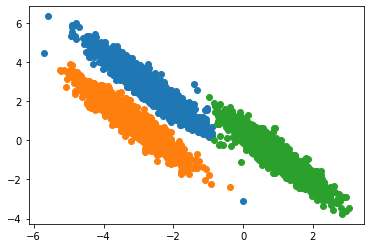

true clusters


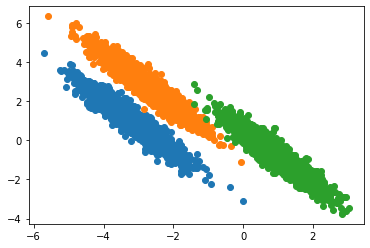

------------------------------
sample: 1
our time is: 0:00:03.483947
our accuracy is: 0.9973333333333333
our nmi is: 0.9830345149117167
our method clusters


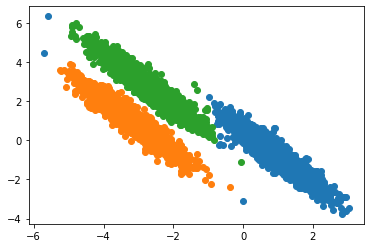

spectral clustering time is: 0:00:05.554967
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025115
spectral clustering clusters


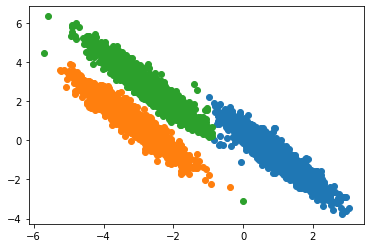

true clusters


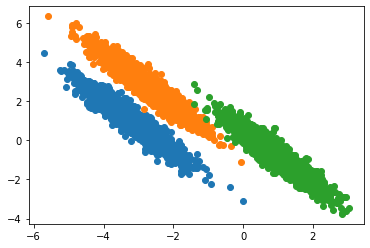

------------------------------
sample: 2
our time is: 0:00:03.273079
our accuracy is: 0.9971666666666666
our nmi is: 0.9821657158157394
our method clusters


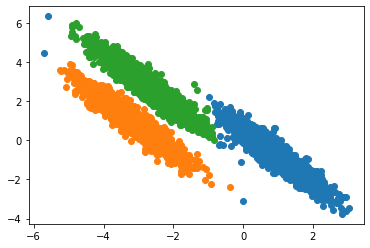

spectral clustering time is: 0:00:05.886999
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025113
spectral clustering clusters


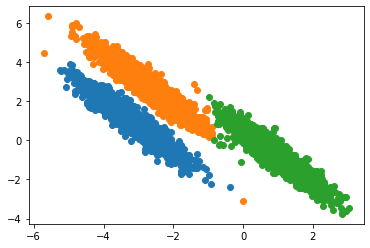

true clusters


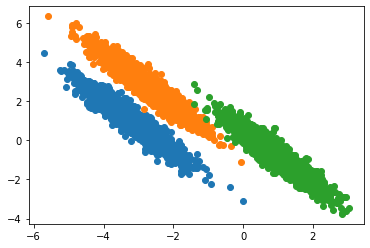

------------------------------
our time is: 0:00:04.007561
our accuracy is: 0.9971666666666666
our nmi is: 0.9821657158157394
our method clusters


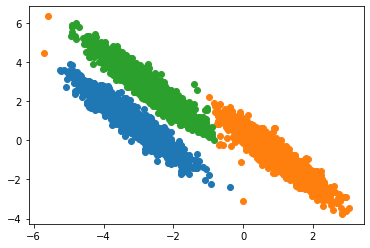

spectral clustering time is: 0:00:07.504476
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025115
spectral clustering clusters


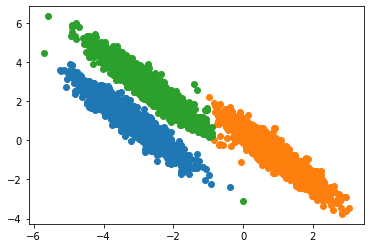

true clusters


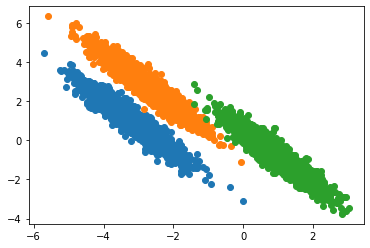

(0.9971666666666666,
 0.9821657158157394,
 datetime.timedelta(seconds=4, microseconds=7561),
 0.9971666666666666,
 0.9821657930025115,
 datetime.timedelta(seconds=7, microseconds=504476))

In [26]:
for i in range(3):
    print('sample:', i)
    run_aniso1(1.0, 0.3, True)
    print('------------------------------')


run_aniso1(1.0, 0.3, True) 
